# Apoferritin PDB dataset

> Georgios Varnavides | Oct 24 2025  
>
> Sample: apoferritin PDB dataset  
> Sampling conditions: ~10 Ang step-sizes  
> Imaging conditions: 4 mrad, 1.5 um defocus  

In [26]:
import ase
import abtem
import gemmi

import matplotlib.pyplot as plt
import numpy as np
import scipy
import tqdm
import itertools

### PDB to ASE

This is arguably the trickiest step. We use the `gemmi` library to import *.pdb files. 

Note *.pdb files usually only store the asymmetric unit - so instead we download the "biological assembly" file from the [RCSB PDB](https://www.rcsb.org/structure/8RQB), and loop over all symmetrically-equivalent units.

Here, we use the 8rqb record for the apoferritin molecule.

In [2]:
# load PDB file
structure = gemmi.read_pdb("../data/8rqb.pdb1")

# initialize xyz coordinates list
xyz_list = []

# loop over biological assemblies
for n_asu in range(len(structure)):
    model = structure[n_asu]
    residues = [res for ch in model for res in ch]
    xyz = np.array([[np.append(atom.pos.tolist(),atom.element.atomic_number) for res in residues for atom in res]])
    xyz_list.append(xyz)

# convert to numpy arraty and reshape
xyz = np.array(xyz_list)
xyz = xyz.reshape((xyz.shape[0],) + xyz.shape[2:])

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

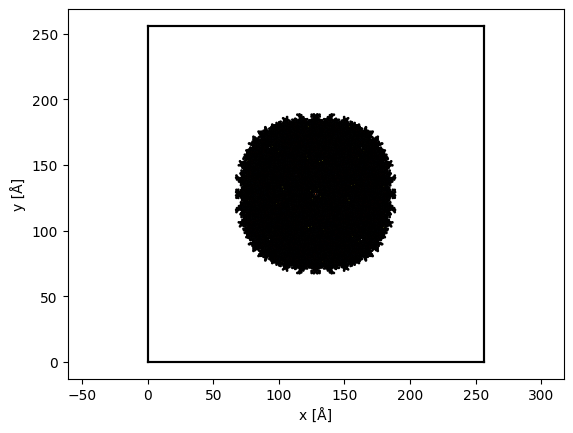

In [3]:
# convert xyz coordinates in Ang, into an ASE atoms object
pdb_atoms = ase.Atoms(
    numbers= xyz[:,:,3].ravel(),
    positions=xyz[:,:,:3].reshape((-1,3)),
    cell=[256,256,256], # fixed cell-size specification
)

# center atoms in fov
pdb_atoms.center()

abtem.show_atoms(pdb_atoms)

### Ice-Embedding

Our protein above is in vacuum. To ensure a more realistic simulation, we can further "embed" the structure in vitreous-ice.

We choose a simple continuum approach, described in Shang and Sigworth continuum water model:  https://doi.org/10.1016/j.jsb.2012.04.021.

Essentially, we "coarse-grain" our protein and compute isosurface distances away from the protein surface - on which we evaluate the continuum expression.

In [6]:
def solvent_density_function(r,r1=0.5,r2=1.7,r3=0.7,a2=0.2,a3=-0.15,s1=1,s2=1.77,s3=1.06):
    """ Shang and Sigworth continuum water model:  https://doi.org/10.1016/j.jsb.2012.04.021 """
    return 0.5 + 0.5*scipy.special.erf((r-r1)/np.sqrt(2)/s1) + a2*np.exp(-(r-r2)**2/2/s2**2) + a3*np.exp(-(r-r3)**2/2/s3**2)

# potential in vacuum
potential = abtem.Potential(
    pdb_atoms,
    slice_thickness=1, # sampling in A
    sampling=(1,1), # sampling in A
).build(
    lazy=False,
)

# transposed to xyz
potential_array_xyz = np.ascontiguousarray(potential.array.transpose(1,2,0))

# coarse-grain
potential_array_filtered = scipy.ndimage.gaussian_filter(potential_array_xyz,5)

# compute distance from protein surface 
protein_surface = potential_array_filtered < 2 # note this factor is empirically determined, might need fiddling with
protein_distance = scipy.ndimage.distance_transform_edt(protein_surface)

# evaluate solvent density equation on
solvent_density = solvent_density_function(protein_distance)
embedded_potential_xyz = (solvent_density*3.6) + potential_array_xyz

# upsample by 3/2 (to account for abtem's 2/3 antialiasing aperture)
embedded_potential_array_xyz = scipy.ndimage.zoom(embedded_potential_xyz,3/2)

In [7]:
print(embedded_potential_array_xyz.shape)

res = embedded_potential_array_xyz.shape[0] # number of pixels
pixel_size = 2/3 # A
bin_factor_z = res//32 # factor to bin along the beam direction

(384, 384, 384)


In [8]:
defocus = 1.5e4 # 1.5 um
semiangle  = 4 # mrad
energy = 300e3 # V

[########################################] | 100% Completed | 105.74 ms


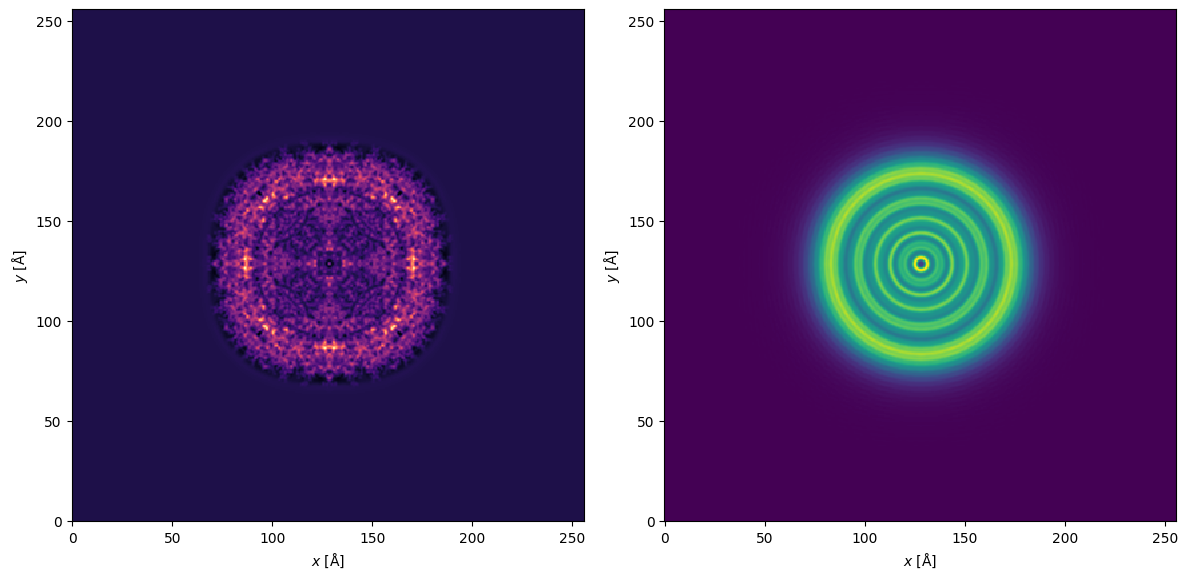

In [11]:
binned_volume_xyz = embedded_potential_array_xyz.reshape((
        res,
        res,
        res//bin_factor_z,
        bin_factor_z
    )).sum(-1)

binned_volume_zxy = binned_volume_xyz.transpose(2,0,1) # abtem expects the first dimension to be z

potential = abtem.PotentialArray(
    binned_volume_zxy,
    slice_thickness=pixel_size*bin_factor_z,
    sampling=(pixel_size,pixel_size),
)

probe = abtem.Probe(
    energy=energy,
    semiangle_cutoff = semiangle,
    defocus = defocus,
)
probe.match_grid(potential)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    
(potential.project()* abtem.core.energy.energy2sigma(energy)).show(
    ax=ax1,
    cmap='magma',
)

probe.show(ax =ax2);

fig.tight_layout()

### Random Orientations

We want to place multiple, randomly orientated, apoferritin samples in the field of view - so we write a simple utility to rotate, bin, and tranpose the volume.

In [14]:
def rotate_xyz_volume(
    volume_array,
    rot_matrix,
    order=3,
):
    """ 3D volume rotation using spline interpolation """
    
    volume = volume_array.copy()
    volume_shape = np.asarray(volume.shape)
    tf = np.asarray(rot_matrix.T)
    
    in_center = (volume_shape - 1) / 2
    out_center = tf @ in_center
    offset = in_center - out_center
    
    volume = scipy.ndimage.affine_transform(volume,tf,offset=offset,order=order,cval=3.6) # ice-voltage
    
    return volume

def randomly_rotate_volume(vol,seed=None):
    """ rotate, bin, and transpose volume """
    rot_mat = scipy.spatial.transform.Rotation.random(random_state=seed).as_matrix()
    rotated_volume = rotate_xyz_volume(vol,rot_mat)
    resized_volume = rotated_volume.reshape((
        res,
        res,
        res//bin_factor_z,
        bin_factor_z
    )).sum(-1)
    return resized_volume.transpose(2,0,1)

def potential_and_probe(vol,seed=None):
    """ return rotated potential array and probe """
    rotated_vol = randomly_rotate_volume(vol,seed)
    
    potential = abtem.PotentialArray(
        rotated_vol,
        slice_thickness=pixel_size*bin_factor_z,
        sampling=(pixel_size,pixel_size),
    )
    
    probe = abtem.Probe(
        energy=energy,
        semiangle_cutoff = semiangle,
        defocus = defocus,
    )
    probe.match_grid(potential)

    return potential,probe

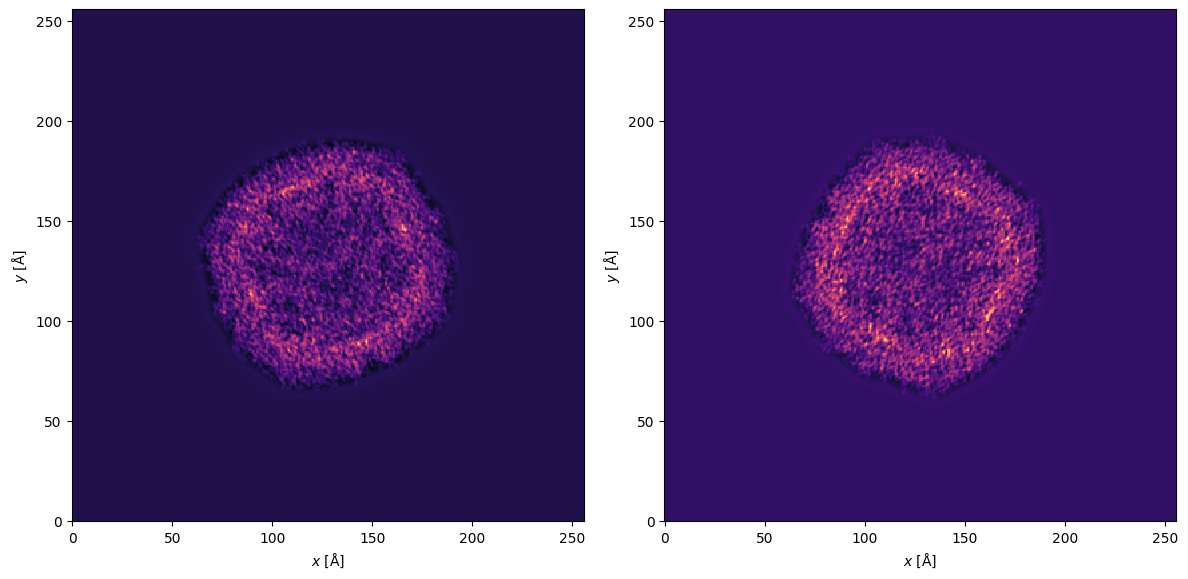

In [15]:
potential_01, _ = potential_and_probe(embedded_potential_array_xyz)
potential_02, _ = potential_and_probe(embedded_potential_array_xyz)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    
potential_01.project().show(
    ax=ax1,
    cmap='magma',
)

potential_02.project().show(
    ax=ax2,
    cmap='magma',
)

fig.tight_layout()

### Simulation
Since these are so large (and surrounded by a constant potential), we will simulate them one at a time.

In [20]:
num_probes_per_particle = 24
bin_factor = 2

pixelated_detector = abtem.PixelatedDetector(
    max_angle="cutoff",
)

grid_scan = abtem.GridScan(
    (0, 0),
    (res*pixel_size,res*pixel_size),
    gpts=(num_probes_per_particle+1,num_probes_per_particle+1),
    endpoint=True,
)

def binned_array_from_seed(seed=None,rotation_deg=None):
    potential,probe = potential_and_probe(embedded_potential_array_xyz,seed)
    measurement = probe.scan(
        potential=potential,
        scan=grid_scan,
        detectors=pixelated_detector,
        lazy=False,
    ).array

    if rotation_deg is not None:
        measurement = scipy.ndimage.rotate(measurement,rotation_deg,reshape=False,axes=(-2,-1),order=1)

    sx,sy,qx,qy = measurement.shape
    measurement = measurement.reshape((
        sx,
        sy,
        qx//bin_factor,
        bin_factor,
        qy//bin_factor,
        bin_factor
    )).sum((3,5))

    # np.random.seed(seed)
    # noisy_array = np.random.poisson((measurement * electron_dose_per_probe).clip(0)).astype(np.uint16)

    return measurement

In [31]:
n = 3
tx = ty = n*num_probes_per_particle+1
large_4ddataset =np.zeros((tx,ty,res//3*2//bin_factor,res//3*2//bin_factor),dtype=np.float32)

for ix, iy in tqdm.tqdm(itertools.product(range(3),range(3))):
    seed = ix*n+iy
    binned_array = binned_array_from_seed(seed,15)
    large_4ddataset[
        ix*num_probes_per_particle:(ix+1)*num_probes_per_particle+1,
        iy*num_probes_per_particle:(iy+1)*num_probes_per_particle+1
    ] = binned_array

9it [17:04, 113.87s/it]


In [38]:
import quantem as em

sampling = [
    grid_scan.sampling[0],
    grid_scan.sampling[1],
    probe.angular_sampling[0]*bin_factor,
    probe.angular_sampling[1]*bin_factor,
]

units = ["A","A","mrad","mrad"]

dataset = em.core.datastructures.Dataset4dstem.from_array(
    large_4ddataset,
    sampling=sampling,
    units=units,
)

dataset.save("../data/apoF_4mrad_1.5um-df_10A-step.zip",mode='o')